## Transfered Learning Bees vs Ants

Used pretrained RESNET18 as fixed feature extractor.   

Freeze the weights for all of the network except that of the final fully connected layer. The last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline

### Load and view data

In [4]:
PATH = "hymenoptera_data/"

In [5]:
os.listdir(PATH)

['train', 'valid']

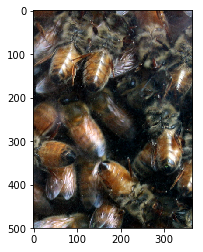

In [6]:
files = os.listdir(f'{PATH}valid/bees')[:5]
img = plt.imread(f'{PATH}valid/bees/{files[0]}')
plt.imshow(img)

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
batch_size = 4

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

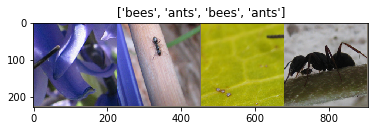

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### Define model train and validation accuracy/loss

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        model.train()
        scheduler.step()
        
        total = 0
        sum_loss = 0.0
        correct = 0
        
        # Iterate over data.
        for data in dataloaders['train']:
            inputs, labels = data
            batch = inputs.shape[0]
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

         # statistics
            total += batch
            sum_loss += batch * loss.data[0]
            correct += torch.sum(preds == labels.data)
            
        epoch_loss_train = sum_loss / total
        epoch_acc_train = correct / total
            
        epoch_acc_val, epoch_loss_val = model_accuracy_loss(model, dataloaders['valid'])
            
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))
        print('Valid Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))

        # deep copy the model
        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())

    print('-' * 10)
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def model_accuracy_loss(model, val_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for data in val_loader:
        inputs, labels = data
        batch = inputs.shape[0]
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)
        _,preds = torch.max(outputs.data,1)
        loss = criterion(outputs,labels)
        sum_loss += batch * loss.data[0]
        total += batch
        correct += torch.sum(preds == labels.data)
    return 100*correct/total, sum_loss/total

### Load pretrained resnet18 and unfreeze the last layer for training

In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/Grace/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:11<00:00, 3924397.19it/s]


Epoch 0/24
----------
Train Loss: 0.6050 Acc: 0.6803
Valid Loss: 0.2664 Acc: 91.5033
Epoch 1/24
----------
Train Loss: 0.6722 Acc: 0.6885
Valid Loss: 0.2496 Acc: 92.8105
Epoch 2/24
----------
Train Loss: 0.4059 Acc: 0.8320
Valid Loss: 0.2167 Acc: 94.1176
Epoch 3/24
----------
Train Loss: 0.5630 Acc: 0.7623
Valid Loss: 0.2313 Acc: 92.1569
Epoch 4/24
----------
Train Loss: 0.5886 Acc: 0.7336
Valid Loss: 0.4421 Acc: 83.6601
Epoch 5/24
----------
Train Loss: 0.3891 Acc: 0.8320
Valid Loss: 0.2663 Acc: 90.1961
Epoch 6/24
----------
Train Loss: 0.5666 Acc: 0.7705
Valid Loss: 0.1915 Acc: 93.4641
Epoch 7/24
----------
Train Loss: 0.3196 Acc: 0.8770
Valid Loss: 0.1889 Acc: 92.8105
Epoch 8/24
----------
Train Loss: 0.3444 Acc: 0.8525
Valid Loss: 0.1756 Acc: 93.4641
Epoch 9/24
----------
Train Loss: 0.3709 Acc: 0.8607
Valid Loss: 0.1696 Acc: 92.8105
Epoch 10/24
----------
Train Loss: 0.3292 Acc: 0.8484
Valid Loss: 0.1777 Acc: 92.1569
Epoch 11/24
----------
Train Loss: 0.3554 Acc: 0.8484
Valid Loss

In [ ]:
### Vi

In [21]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for data in dataloaders['valid']:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return 

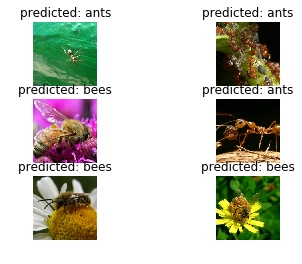

In [22]:
visualize_model(model_conv)